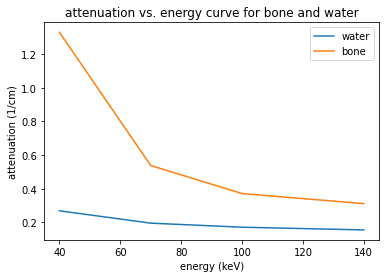

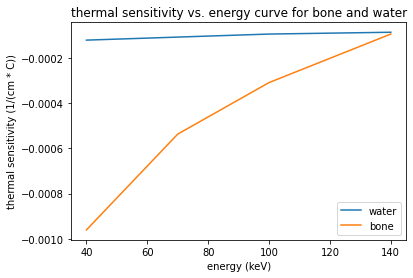

In [2]:
# DATA CALIBRATION FOR MODEL
# - attenuation vs. energy for water and bone
# - thermal sensitivity vs. energy for water and bone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random

# x_series: array of x values
# y_series: size n list of array of y values
# labels: size n list of labels corresponding to y_series
def line_plot(x_series, y_series, labels, title, ylabel, xlabel):
    for i in range(len(y_series)):
        plt.plot(x_series, y_series[i], label = labels[i])
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()

# source: https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html
df_bone = pd.read_excel('bone_attenuation_curve.xlsx')
df_water = pd.read_excel('water_attenuation_curve.xlsx')
x_bone = np.array(df_bone['energy (MeV)']) * 1000 # convert MeV to keV
y_bone = np.array(df_bone['mass attenuation (cm^2/g)'])
x_water = np.array(df_water['energy (MeV)']) * 1000
y_water = np.array(df_water['mass attenuation (cm^2/g)'])

water_attenuations = np.array([])
bone_attenuations = np.array([])

energy_levels = np.array([40, 70, 100, 140]) # in keV or kvP
num_energy_levels = energy_levels.size

# interpolate attenuations for each energy level
bone_attenuations = np.interp(energy_levels, x_bone, y_bone) * 2 # density = 2g/cm^3
water_attenuations = np.interp(energy_levels, x_water, y_water)

# attenuation vs. energy plot
line_plot(energy_levels, 
          [water_attenuations, bone_attenuations],
          ['water', 'bone'], 
          'attenuation vs. energy curve for bone and water',
          'attenuation (1/cm)',
          'energy (keV)')
plt.show()

# source: https://link.springer.com/content/pdf/10.1007/s00330-021-08206-z.pdf       
water_alphas_HU = np.array([-0.45, -0.4, -0.35, -0.32])
bone_alphas_HU = np.array([-3.58, -2, -1.15, -0.35])

# convert thermal sensitivity from HU/C to mu/C (ie. 1/(C*cm))
# water_alphas = np.multiply((water_alphas_HU / 1000), water_attenuations)
# bone_alphas = np.multiply((bone_alphas_HU / 1000), water_attenuations)

water_alphas = (water_alphas_HU / 1000) * water_attenuations[0]
bone_alphas = (bone_alphas_HU / 1000) * water_attenuations[0]

# thermal sensitivity vs. energy plot
line_plot(energy_levels, 
          [water_alphas, bone_alphas],
          ['water', 'bone'], 
          'thermal sensitivity vs. energy curve for bone and water',
          'thermal sensitivity (1/(cm * C))',
          'energy (keV)')
plt.show()

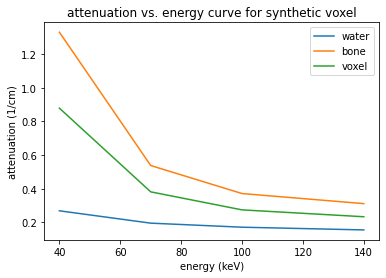

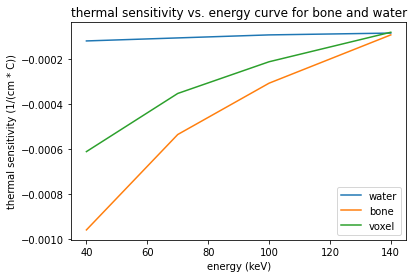

In [10]:
# GENERATE VOXEL
# - generates the attenuation and thermal sensitivity properties of a voxel
# - mu_voxel = V_w * mu_water + V_b * mu_bone                                      
# - alpha_voxel = V_w * alpha_w  + V_b * alpha_b where alpha has units of HU/C or 1/(C*cm) 

def generate_voxel(V_w, V_b): 
    # water and bone attenuations and alphas are global data
    voxel_attenuations = V_w * water_attenuations + V_b * bone_attenuations # exact physical law
    voxel_alphas = V_w * water_alphas + V_b * bone_alphas # model assumption
                                       
    return voxel_attenuations, voxel_alphas

volume_fractions = np.array([0.3, 0.6, 0.1])
V_w = volume_fractions[0]
V_b = volume_fractions[1]
voxel_attenuations, voxel_alphas = generate_voxel(V_w, V_b)
                                       
# attenuation vs. energy of voxel
line_plot(energy_levels, 
          [water_attenuations, bone_attenuations, voxel_attenuations],
          ['water', 'bone', 'voxel'], 
          'attenuation vs. energy curve for synthetic voxel',
          'attenuation (1/cm)',
          'energy (keV)')
plt.show()
    
# thermal sensitivity vs. energy of voxel
line_plot(energy_levels, 
          [water_alphas, bone_alphas, voxel_alphas],
          ['water', 'bone', 'voxel'], 
          'thermal sensitivity vs. energy curve for bone and water',
          'thermal sensitivity (1/(cm * C))',
          'energy (keV)')
plt.show()

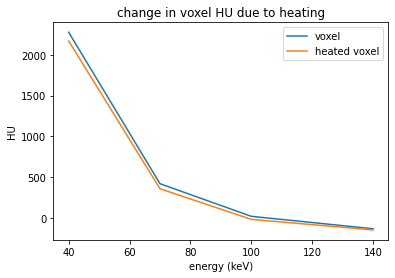

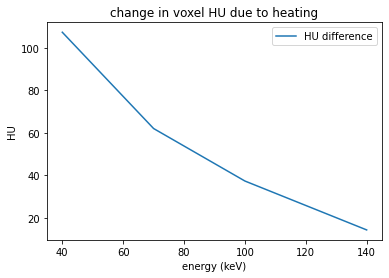

In [11]:
# HEAT VOXEL
# - decrease attenuation by alpha(E) times the change in temperature in each energy bin

# gt_temp: heated temperature
# voxel_attenuations and voxel_alphas: obtained from generate_voxel()
# t0_temp = 23: default reference temperature
def heat_voxel(gt_temp, voxel_attenuations, voxel_alphas, t0_temp=23): 
    heated_voxel_attenuations = np.copy(voxel_attenuations)
    delta_T = gt_temp - t0_temp
    
    heated_voxel_attenuations += delta_T * voxel_alphas
    
    return heated_voxel_attenuations

# convert from linear attenuation to HU
def HU_to_mu(HU_values):
    # return np.multiply(HU_values / 1000, water_attenuations) + water_attenuations
    return (HU_values / 1000) * water_attenuations[0] + water_attenuations[0]

# convert from linear attenuation to HU
def mu_to_HU(attenuations):
    # return ((attenuations - water_attenuations) / water_attenuations) * 1000
    return ((attenuations - water_attenuations[0]) / water_attenuations[0]) * 1000

gt_temp = 70
heated_voxel_attenuations = heat_voxel(gt_temp, voxel_attenuations, voxel_alphas)

voxel_HU = mu_to_HU(voxel_attenuations)
heated_voxel_HU = mu_to_HU(heated_voxel_attenuations)
delta_HU = voxel_HU - heated_voxel_HU

line_plot(energy_levels, 
          [voxel_HU, heated_voxel_HU],
          ['voxel', 'heated voxel'], 
          'change in voxel HU due to heating',
          'HU',
          'energy (keV)')
plt.show()

line_plot(energy_levels, 
          [delta_HU],
          ['HU difference'], 
          'change in voxel HU due to heating',
          'HU',
          'energy (keV)')
plt.show()

In [14]:
# METHOD 1: TWO STEP ALGORITHM
# - computes material decomposition and predicts temperature separately
# - does not account for thermal error in material decomposition

# voxel_attenuations: obtained from generate_voxel()
# heated_voxel_attenuations: obtained from heat_voxel()
# error_level: standard deviation of Gaussian noise in HU
def two_step_algorithm(heated_voxel_attenuations, voxel_attenuations, error_level):
    random_err = np.random.normal(0, error_level)
    noisy_voxel_HU = mu_to_HU(heated_voxel_attenuations) + random_err
    noisy_voxel_mu = HU_to_mu(noisy_voxel_HU)
    
    col_1 = np.expand_dims(water_attenuations, axis=1)
    col_2 = np.expand_dims(bone_attenuations, axis=1)
    col_3 = np.expand_dims(np.zeros(4), axis=1)
    row_5 = np.expand_dims(np.ones(3), axis=0)
    
    coefficient_mtx = np.concatenate([col_1, col_2, col_3], axis=1)
    coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0)
    print(coefficient_mtx.shape)
    print('coefficients')
    print(coefficient_mtx)
    print('')
    
    conditions = np.expand_dims(np.append(noisy_voxel_mu, 1), axis=1)
    print(conditions.shape)
    print('conditions')
    print(conditions)
    print('')
    
    inverse = np.linalg.pinv(coefficient_mtx)

    uncorrected_volume_fractions = np.matmul(inverse, conditions)
    V_w = uncorrected_volume_fractions[0]
    V_b = uncorrected_volume_fractions[1]
    
    print(V_w)
    print(V_b)
    volume_fraction_errors = uncorrected_volume_fractions.flatten() - volume_fractions
    
    voxel_HU = mu_to_HU(voxel_attenuations)
    noisy_delta_HU = voxel_HU - noisy_voxel_HU
    
    pred_temp_arr = np.array([])
    
    # temperature prediction made in the HU domain
    # compute HU/C thermal sensitivity
    alpha_wb = V_w * water_alphas_HU + V_b * bone_alphas_HU
    pred_temp_arr = np.divide(-noisy_delta_HU, alpha_wb) + 23
    
    avg_temp_pred = np.mean(pred_temp_arr)
    mae_volume_fraction = np.mean(np.absolute(volume_fraction_errors)) * 100
    
    return avg_temp_pred, mae_volume_fraction

val1, val2 = two_step_algorithm(heated_voxel_attenuations, voxel_attenuations, 0)

print(val1)
print(val2)

(5, 3)
coefficients
[[0.2683  1.331   0.     ]
 [0.1948  0.5377  0.     ]
 [0.1707  0.371   0.     ]
 [0.15454 0.311   0.     ]
 [1.      1.      1.     ]]

(5, 1)
conditions
[[0.85030114]
 [0.36441467]
 [0.26378497]
 [0.22910331]
 [1.        ]]

[0.28790886]
[0.58028084]
71.65292833120144
2.1206864936919487


In [6]:
# METHOD 2: ONE STEP ALGORITHM
# convert to HU domain

def one_step_algorithm(heated_voxel_attenuations, error_level):
    heated_voxel_HU = mu_to_HU(heated_voxel_attenuations)
    noisy_heated_voxel = heated_voxel_HU + np.random.normal(0, error_level)
    water_HU = mu_to_HU(water_attenuations)
    bone_HU = mu_to_HU(bone_attenuations)
    
    col_1 = np.expand_dims(water_HU, axis=1)
    col_2 = np.expand_dims(bone_HU, axis=1)
    col_3 = np.expand_dims(np.zeros(4), axis=1) - 1000
    col_4 = np.expand_dims(water_alphas_HU, axis=1)
    col_5 = np.expand_dims(bone_alphas_HU, axis=1)

    row_5 = np.expand_dims(np.array([1, 1, 1, 0, 0]), axis=0)
    
    coefficient_mtx = np.concatenate([col_1, col_2, col_3, col_4, col_5], axis=1)
    coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0)
    print(coefficient_mtx.shape)
    print('coefficients')
    print(coefficient_mtx)
    print('')

    conditions = np.expand_dims(np.append(noisy_heated_voxel, 1), axis=1)
    print(conditions.shape)
    print('conditions')
    print(conditions)
    print('')
    
    inverse = np.linalg.inv(coefficient_mtx)
    # print(inverse.shape)

    output = np.matmul(inverse, conditions)
    print('output')
    print(output)
    print('')

    print(output[4]/output[1] + 23)
    print(output[3]/output[0] + 23)
    print('')
    
    print('coefficient_mtx * output')
    print(np.matmul(coefficient_mtx, output))
    print('')
    
    return output
    
output = one_step_algorithm(heated_voxel_attenuations, error_level=0)


(5, 5)
coefficients
[[ 0.00000000e+00  3.96086470e+03 -1.00000000e+03 -4.50000000e-01
  -3.58000000e+00]
 [-2.73947074e+02  1.00409989e+03 -1.00000000e+03 -4.00000000e-01
  -2.00000000e+00]
 [-3.63771897e+02  3.82780470e+02 -1.00000000e+03 -3.50000000e-01
  -1.15000000e+00]
 [-4.24002982e+02  1.59150205e+02 -1.00000000e+03 -3.20000000e-01
  -3.50000000e-01]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]]

(5, 1)
conditions
[[  16.98754704]
 [-280.71860455]
 [-373.13237346]
 [-433.22554987]
 [   1.        ]]

output
[[9.90000000e-01]
 [1.00000000e-02]
 [1.42108547e-14]
 [4.65300000e+01]
 [4.70000000e-01]]

[70.]
[70.]

coefficient_mtx * output
[[  16.98754704]
 [-280.71860455]
 [-373.13237346]
 [-433.22554987]
 [   1.        ]]



In [33]:
# METHOD 3: ITERATIVE
# - T_n is our temperature prediction that becomes more accurate over each iteration
# - start with n = 0 and thus T_0 = 23 C
# - 1. perform material decomposition at T_n, obtaining V_wn and V_bn
# - 2. predict the temperature, T_(n+1)
# - 3. return to step 1 with T_n = T_(n+1)

def material_decomposition(mu_of_E, temp):
    corrected_water_mu = water_attenuations + water_alphas * (temp - 23)
    corrected_bone_mu = bone_attenuations + bone_alphas * (temp - 23)

    col_1 = np.expand_dims(corrected_water_mu, axis=1)
    col_2 = np.expand_dims(corrected_bone_mu, axis=1)
    col_3 = np.expand_dims(np.zeros(4), axis=1)
    row_5 = np.expand_dims(np.ones(3), axis=0)
    
    coefficient_mtx = np.concatenate([col_1, col_2, col_3], axis=1)
    coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0)
    
    conditions = np.expand_dims(np.append(mu_of_E, 1), axis=1)
    
    inverse = np.linalg.pinv(coefficient_mtx)

    uncorrected_volume_fractions = np.matmul(inverse, conditions)
    V_w = uncorrected_volume_fractions[0]
    V_b = uncorrected_volume_fractions[1]
    
    return V_w, V_b
    
def temperature_prediction(V_w, V_b, delta_HU): 
    pred_temp_arr = np.array([])
    
    # temperature prediction made in the HU domain
    # compute HU/C thermal sensitivity
    alpha_wb = V_w * water_alphas_HU + V_b * bone_alphas_HU
    pred_temp_arr = np.divide(-noisy_delta_HU, alpha_wb) + 23
    
    pred_temp = np.mean(pred_temp_arr)

    return pred_temp

def iterative_algorithm(threshold):
    voxel_temp = 23
    i = 0
    delta_temp = 10

    temp_iter_array = np.array([])
    Vw_iter_array = np.array([])
    Vb_iter_array = np.array([])

    while(np.abs(delta_temp) > threshold):
        V_w, V_b = material_decomposition(noisy_voxel_mu, voxel_temp)
        Vw_iter_array = np.append(Vw_iter_array, V_w)
        Vb_iter_array = np.append(Vb_iter_array, V_b)

        voxel_temp = temperature_prediction(V_w, V_b, noisy_delta_HU)
        temp_iter_array = np.append(temp_iter_array, voxel_temp)

        i += 1

        if i > 1: 
            delta_temp = temp_iter_array[i-1] - temp_iter_array[i-2]

    return temp_iter_array

error_level = 100
roi_temp_vals = np.array([])

for i in range(1):
    random_err = np.random.normal(0, error_level)
    noisy_voxel_HU = mu_to_HU(heated_voxel_attenuations) + random_err
    noisy_voxel_mu = HU_to_mu(noisy_voxel_HU) # material_decomposition
    voxel_HU = mu_to_HU(voxel_attenuations)
    noisy_delta_HU = voxel_HU - noisy_voxel_HU # temperature_prediction
    
    temp_iter_array = iterative_algorithm(0.25)
    iterations = temp_iter_array.size
    
    roi_temp_vals = np.append(roi_temp_vals, temp_iter_array[iterations-1])

print(np.mean(roi_temp_vals))
print(np.std(roi_temp_vals))
    

77.08264381460789
0.0


In [7]:
# GENERATE STATISTICS
# global: water_attenuations, bone_attenuations, water_alphas_HU, bone_alphas_HU, water_alphas, bone_alphas

# def generate_voxel(volume_fractions):
# returns: voxel_attenuations, voxel_alphas

# def heat_voxel(gt_temp, voxel_attenuations, voxel_alphas):
# returns: heated_voxel_attenuations
# global: voxel_HU, heated_voxel_HU, delta_HU

# def two_step_algorithm(heated_voxel_attenuations_error_level):
# returns: np.mean(pred_temp_arr), volume_fraction_errors

percent_water = [0, 20, 40, 60, 80, 100]
error_levels = np.arange(0, 6, 1) # std. dev. of HU error

for k in percent_water:
    for error_level in error_levels:
        # col_1: ground truth temperature, col_2: average predicted temperature, col_3: stdev of predicted temperature
        # col_4: MAE of temperature col_5: MAE vol_frac_error
        data_file = np.empty((0, 5)) 

        temps = np.arange(23, 91, 1) # temperature of synthetic voxel

        for temp in temps:
            samples = 100 # number of pixels in 10x10 ROI

            pred_temp_arr = np.array([])
            vol_frac_err_arr = np.array([])

            for i in range(samples):
                volume_fractions = np.array([k, 100-k, 0], dtype='float') # idx0: V_w, idx1: V_b, idx2: V_a
                volume_fractions /= np.sum(volume_fractions) # normalize

                voxel_attenuations, voxel_alphas = generate_voxel(volume_fractions)
                heated_voxel_attenuations = heat_voxel(temp, voxel_attenuations, voxel_alphas)

                pred_temp, vol_frac_error = two_step_algorithm(heated_voxel_attenuations, voxel_attenuations, error_level)
                pred_temp_arr = np.append(pred_temp_arr, pred_temp)
                vol_frac_err_arr = np.append(vol_frac_err_arr, vol_frac_error)

            # temp loop
            avg_pred_temp = np.mean(pred_temp_arr)
            stdev_pred_temp = np.std(pred_temp_arr) 
            MAE_temp = np.mean(np.absolute(pred_temp_arr - temp))
            MAE_vol_frac = np.mean(vol_frac_err_arr)

            data_row = np.expand_dims(np.array([temp, avg_pred_temp, stdev_pred_temp, MAE_temp, MAE_vol_frac]), axis=0)
            data_file = np.append(data_row, data_file, axis = 0)  

        # error loop
        data_file
        df = pd.DataFrame(data_file)
        path = r'C:\Users\Nathan\Deep Learning\ct-thermometry\simulation_data\two_step_algorithm\error_level_' + str(error_level) + 'percent_water' + str(k) + '.xlsx'
        df.to_excel(excel_writer = path)

    # material loop
    
# outside loops

TypeError: generate_voxel() missing 1 required positional argument: 'V_b'

(6,)
(6,)


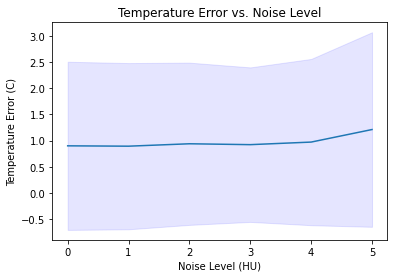

In [28]:
# VISUALIZATIONS

error_level_x = np.arange(0, 6, 1)
mae_temp_y = np.array([])
stdev_temp_y = np.array([])
k = 40

for i in error_level_x:
    path = r'simulation_data\two_step_algorithm\error_level_' + str(i) + 'percent_water' + str(k) + '.xlsx'
    df = pd.read_excel(path)
    df = df.drop('Unnamed: 0', axis=1)

    actual_temp = df[0]
    pred_temp = df[1]
    # stdev_pred_temp = df[2]
    # mae_temp = df[3]
    # mae_temp_y = np.append(mae_temp_y, np.mean(mae_temp))
    mae_temp_y = np.append(mae_temp_y, np.mean(np.absolute(actual_temp - pred_temp)))
    stdev_temp_y = np.append(stdev_temp_y, np.std(np.absolute(actual_temp - pred_temp)))
    # mae_vol_frac = df[4]
    
plt.plot(error_level_x, mae_temp_y)

plt.title('Temperature Error vs. Noise Level')
plt.ylabel('Temperature Error (C)')
plt.xlabel('Noise Level (HU)')

ci = 1.96 * stdev_temp_y
print(error_level_x.shape)
print(ci.shape)
plt.fill_between(error_level_x, (mae_temp_y-ci), (mae_temp_y+ci), color='b', alpha=.1)

plt.show()

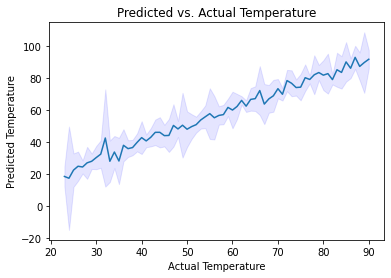

In [12]:
i=2.0
path = r'simulation_data\two_step_algorithm\error_level_' + str(i) + '.xlsx'
df = pd.read_excel(path)
df = df.drop('Unnamed: 0', axis=1)

actual_temp = df[0]
pred_temp = df[1]
stdev_pred_temp = df[2]
mae_temp = df[3]
mae_vol_frac = df[4]

ci = 1.96 * stdev_pred_temp

plt.plot(actual_temp, pred_temp)

plt.title('Predicted vs. Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.xlabel('Actual Temperature')

plt.fill_between(actual_temp, (pred_temp-ci), (pred_temp+ci), color='b', alpha=.1)

plt.show()

(5, 5)
coefficients
[[ 2.68300e-01  1.33100e+00  0.00000e+00 -8.58560e-05 -9.60514e-04]
 [ 1.94800e-01  5.37700e-01  0.00000e+00 -6.23360e-05 -3.89600e-04]
 [ 1.70700e-01  3.71000e-01  0.00000e+00 -5.46240e-05 -1.96305e-04]
 [ 1.54540e-01  3.11000e-01  0.00000e+00 -4.94528e-05 -5.40890e-05]
 [ 1.00000e+00  1.00000e+00  1.00000e+00  0.00000e+00  0.00000e+00]]

(5, 1)
conditions
[[0.26426477]
 [0.19187021]
 [0.16813267]
 [0.15221572]
 [1.        ]]

output
[[ 9.84959901e-01]
 [-1.27675648e-15]
 [ 1.50400993e-02]
 [-3.10374336e-04]
 [-2.77276117e-13]]

[240.17228102]
[22.99968489]

coefficient_mtx * output
[[0.26426477]
 [0.19187021]
 [0.16813267]
 [0.15221572]
 [1.        ]]

